# Análisis del Comportamiento Bimodal de Precipitaciones en Boyacá por Clusters de Elevación

Este notebook implementa un análisis del comportamiento bimodal de precipitaciones en el departamento de Boyacá (Colombia), utilizando datos de CHIRPS 2.0 y evaluando patrones estacionales según clusters de elevación.

In [68]:
# Importaciones necesarias
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import os
import warnings
import sys

# Agregar el directorio raíz al path para importar los módulos personalizados
sys.path.append('../')
from utils.memory_utils import print_memory_usage
# Agregar el directorio raíz al path para importar los módulos personalizados
from utils.custom_logger import get_logger  # Import get_logger from the appropriate module

# Configuración
%matplotlib inline
plt.rcParams['figure.figsize'] = (14, 10)
warnings.filterwarnings('ignore')

# Configurar el logger
logger = get_logger("analisis_bimodal")

In [69]:
def print_memory_usage():
    """
    Imprime información sobre el uso de memoria actual.
    """
    import psutil
    import os
    process = psutil.Process(os.getpid())
    mem_info = process.memory_info()
    print(f"Uso de memoria: {mem_info.rss / (1024 * 1024):.2f} MB")

## 1. Carga y Preparación de Datos

Este apartado se centra en cargar los datos de precipitación y elevación para Boyacá y prepararlos para el análisis bimodal.

In [70]:
def cargar_datos_boyaca(ruta=None):
    """
    Carga los datos de precipitación y elevación para Boyacá.
    
    Args:
        ruta (str): Ruta al archivo netCDF con los datos procesados.
        
    Returns:
        xr.Dataset: Dataset de precipitación y elevación para Boyacá.
    """
    # Si no se proporciona una ruta, usar la ubicación predeterminada
    if ruta is None:
        # Buscar archivos en la estructura del proyecto
        posibles_rutas = [
            "/Users/riperez/Conda/anaconda3/doc/precipitation/output/complete_dataset_with_features.nc"
        ]
        
        for posible_ruta in posibles_rutas:
            if os.path.exists(posible_ruta):
                ruta = posible_ruta
                logger.info(f"Se encontró el archivo de datos en: {ruta}")
                break
                
        if ruta is None:
            raise FileNotFoundError("No se encontró el archivo de datos para Boyacá en las ubicaciones predeterminadas.")
    
    logger.info(f"Cargando datos para Boyacá desde: {ruta}")
    
    # Cargar los datos con chunks para manejar eficientemente datasets grandes
    try:
        ds = xr.open_dataset(ruta)
        logger.info(f"Dataset cargado correctamente. Dimensiones: {ds.dims}")
        print_memory_usage()
        
        return ds
        
    except Exception as e:
        logger.error(f"Error al cargar los datos: {str(e)}")
        raise

In [71]:
# Cargar los datos para Boyacá
try:
    ds_boyaca = cargar_datos_boyaca()
    print("Variables disponibles:")
    for var in ds_boyaca.data_vars:
        print(f"- {var}: {ds_boyaca[var].attrs.get('long_name', 'Sin nombre')}")
        
    # Mostrar rango temporal
    fecha_inicio = ds_boyaca.time.values.min()
    fecha_fin = ds_boyaca.time.values.max()
    print(f"\nRango temporal: {pd.to_datetime(fecha_inicio).date()} a {pd.to_datetime(fecha_fin).date()}")
    print(f"Total de meses: {len(ds_boyaca.time)}")
except Exception as e:
    print(f"Error al cargar los datos para Boyacá: {str(e)}")

Error al cargar los datos para Boyacá: No se encontró el archivo de datos para Boyacá en las ubicaciones predeterminadas.


## 2. Análisis de Patrones Bimodales

Este apartado analiza los patrones bimodales de precipitación en Boyacá, calculando promedios mensuales y visualizándolos por regiones.

In [72]:
def calcular_ciclo_estacional(ds, variable='total_precipitation'):
    """
    Calcula el ciclo estacional (promedio mensual) de una variable.
    
    Args:
        ds (xr.Dataset): Dataset de xarray con datos temporales.
        variable (str): Nombre de la variable a analizar.
        
    Returns:
        xr.Dataset: Dataset con el ciclo estacional calculado.
    """
    logger.info(f"Calculando ciclo estacional para la variable '{variable}'")
    
    # Extraer el mes de cada timestamp
    ds = ds.assign_coords(month=("time", pd.DatetimeIndex(ds.time.values).month))
    
    # Calcular el promedio por mes
    seasonal_cycle = ds.groupby("month").mean()
    
    logger.info("Ciclo estacional calculado correctamente")
    return seasonal_cycle

2025-05-01 13:47:20,853 - INFO - [track: /var/folders/83/c6n8lktn4qx_fwp7ksllkkhn0dhtn2/T/ipykernel_82661/3025834237.py | function: calcular_ciclo_estacional | line: 12] - Calculando ciclo estacional para la variable 'total_precipitation'
2025-05-01 13:47:21,450 - INFO - [track: /var/folders/83/c6n8lktn4qx_fwp7ksllkkhn0dhtn2/T/ipykernel_82661/3025834237.py | function: calcular_ciclo_estacional | line: 20] - Ciclo estacional calculado correctamente


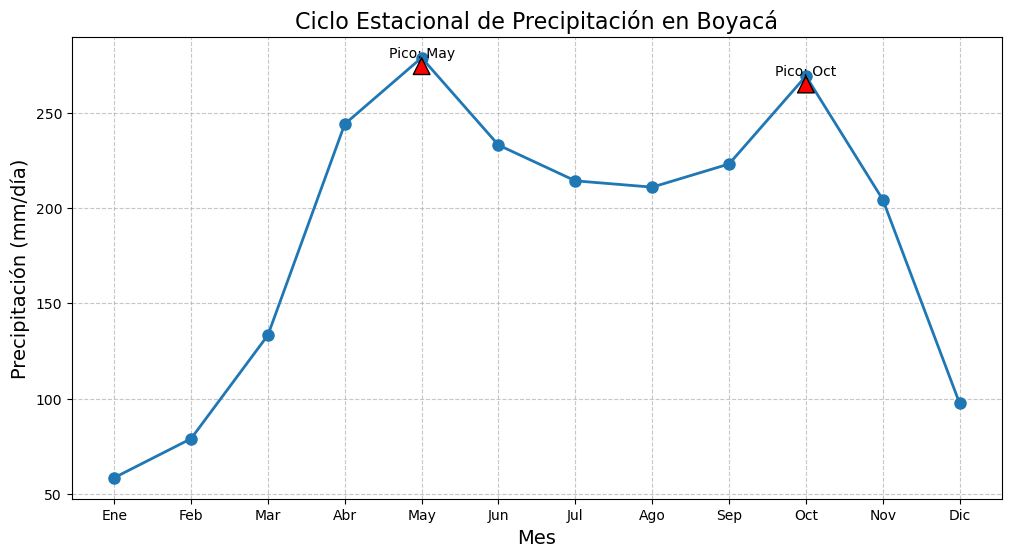

In [73]:
try:
    # Calcular el ciclo estacional para Boyacá
    ciclo_estacional = calcular_ciclo_estacional(ds_boyaca)
    
    # Definir los nombres de los meses para visualización
    nombres_meses = ['Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun', 'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic']
    
    # Calcular el promedio espacial para Boyacá
    precip_promedio_boyaca = ciclo_estacional.total_precipitation.mean(dim=['latitude', 'longitude']).values
    
    # Visualizar el ciclo estacional para Boyacá
    plt.figure(figsize=(12, 6))
    plt.plot(range(1, 13), precip_promedio_boyaca, 'o-', linewidth=2, markersize=8)
    plt.xticks(range(1, 13), nombres_meses)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.title('Ciclo Estacional de Precipitación en Boyacá', fontsize=16)
    plt.ylabel('Precipitación (mm/día)', fontsize=14)
    plt.xlabel('Mes', fontsize=14)
    
    # Identificar los picos
    picos = []
    for i in range(1, len(precip_promedio_boyaca)-1):
        if precip_promedio_boyaca[i] > precip_promedio_boyaca[i-1] and precip_promedio_boyaca[i] > precip_promedio_boyaca[i+1]:
            picos.append((i+1, precip_promedio_boyaca[i]))
    
    # Marcar los picos
    for pico in picos:
        plt.annotate(f'Pico: {nombres_meses[pico[0]-1]}', 
                    xy=(pico[0], pico[1]), 
                    xytext=(pico[0], pico[1]+0.4),
                    arrowprops=dict(facecolor='red', shrink=0.05),
                    ha='center')
    
    plt.show()
except Exception as e:
    print(f"Error al calcular el ciclo estacional: {str(e)}")

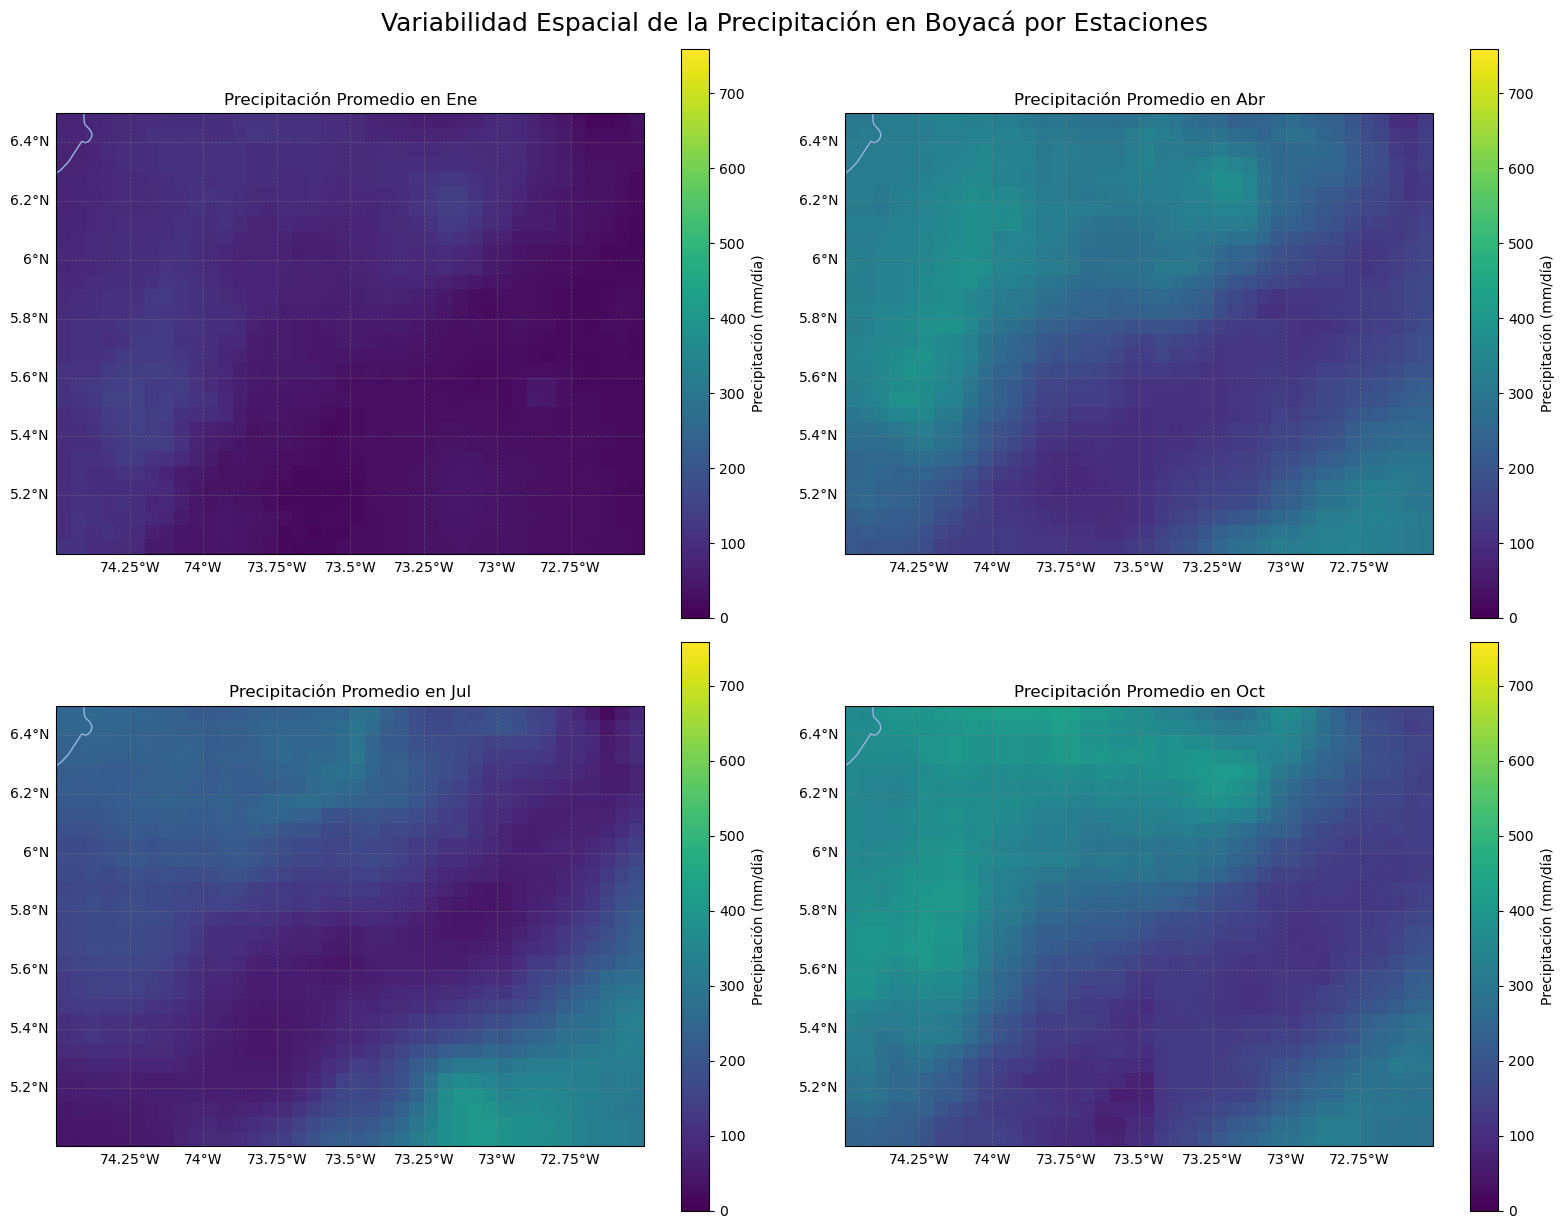

In [74]:
# Visualizar mapas del ciclo estacional para observar la variabilidad espacial
try:
    # Crear mapa con los promedios mensuales
    # Mostrar 4 meses representativos (Enero, Abril, Julio, Octubre)
    meses_mostrar = [1, 4, 7, 10]  # Enero, Abril, Julio, Octubre
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12), subplot_kw={'projection': ccrs.PlateCarree()})
    axes = axes.flatten()
    
    for i, mes in enumerate(meses_mostrar):
        ax = axes[i]
        map_plot = ciclo_estacional.sel(month=mes).total_precipitation.plot(
            ax=ax,
            transform=ccrs.PlateCarree(),
            cmap='viridis',
            vmin=0,
            vmax=ciclo_estacional.total_precipitation.max().item(),
            add_colorbar=True,
            cbar_kwargs={'label': 'Precipitación (mm/día)'}
        )
        
        # Añadir características geográficas
        ax.add_feature(cfeature.COASTLINE, linewidth=1.5)
        ax.add_feature(cfeature.BORDERS, linestyle=':')
        ax.add_feature(cfeature.LAKES, alpha=0.5)
        ax.add_feature(cfeature.RIVERS)
        
        # Añadir grid
        gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
        gl.top_labels = False
        gl.right_labels = False
        
        # Título
        ax.set_title(f'Precipitación Promedio en {nombres_meses[mes-1]}')
        
        # Limitar la vista a Boyacá
        ax.set_extent([-74.5, -72.5, 5.0, 6.5], crs=ccrs.PlateCarree())
    
    plt.tight_layout()
    plt.suptitle('Variabilidad Espacial de la Precipitación en Boyacá por Estaciones', fontsize=18, y=1.02)
    plt.show()
except Exception as e:
    print(f"Error al visualizar los mapas del ciclo estacional: {str(e)}")

In [75]:
# Detección cuantitativa de patrones bimodales
def detectar_bimodalidad(serie_temporal, umbral_pico=0.2):
    """
    Detecta si una serie temporal tiene un patrón bimodal.
    
    Args:
        serie_temporal (array): Serie temporal de datos.
        umbral_pico (float): Umbral para considerar un pico como significativo.
        
    Returns:
        tuple: (es_bimodal, picos, valles)
    """
    # Normalizar la serie
    serie_norm = (serie_temporal - serie_temporal.min()) / (serie_temporal.max() - serie_temporal.min())
    
    # Encontrar picos
    picos = []
    for i in range(1, len(serie_norm) - 1):
        if serie_norm[i] > serie_norm[i-1] and serie_norm[i] > serie_norm[i+1]:
            if i > 0 and i < len(serie_norm) - 1:  # Asegurar que no sean los extremos
                picos.append((i, serie_norm[i]))
    
    # Encontrar valles
    valles = []
    for i in range(1, len(serie_norm) - 1):
        if serie_norm[i] < serie_norm[i-1] and serie_norm[i] < serie_norm[i+1]:
            if i > 0 and i < len(serie_norm) - 1:  # Asegurar que no sean los extremos
                valles.append((i, serie_norm[i]))
    
    # Ordenar picos por altura
    picos_ordenados = sorted(picos, key=lambda x: x[1], reverse=True)
    
    # Se considera bimodal si hay al menos dos picos separados por un valle
    es_bimodal = False
    if len(picos_ordenados) >= 2 and len(valles) >= 1:
        pico1 = picos_ordenados[0]
        pico2 = picos_ordenados[1]
        
        # Verificar que haya un valle entre los dos picos
        valle_entre_picos = None
        for valle in valles:
            indice_valle = valle[0]
            indice_pico1 = pico1[0]
            indice_pico2 = pico2[0]
            
            # Si el valle está entre los dos picos
            if (indice_valle > indice_pico1 and indice_valle < indice_pico2) or \
               (indice_valle > indice_pico2 and indice_valle < indice_pico1):
                valle_entre_picos = valle
                break
        
        if valle_entre_picos:
            # Calcular la profundidad del valle
            prof_valle = min(pico1[1], pico2[1]) - valle_entre_picos[1]
            
            # Es bimodal si la profundidad del valle es significativa
            es_bimodal = prof_valle >= umbral_pico
    
    return es_bimodal, picos, valles

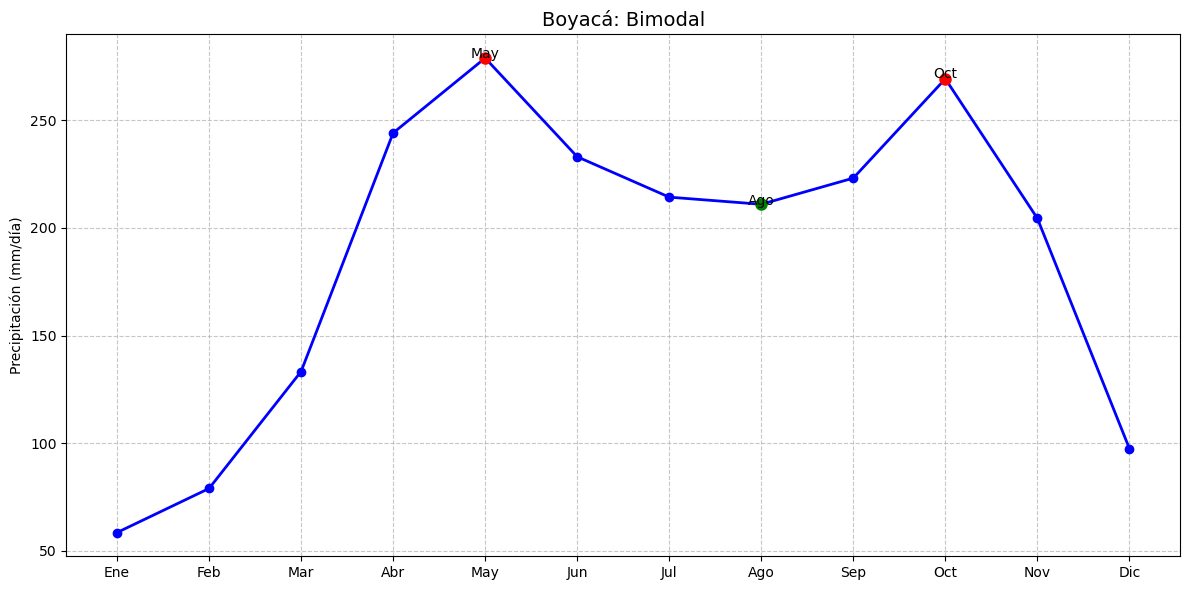


Resumen de bimodalidad en Boyacá:
- Boyacá: BIMODAL
  * Picos principales: May, Oct
  * Valles principales: Ago


In [76]:
try:
    # Detectar bimodalidad en Boyacá
    precip_promedio_boyaca = ciclo_estacional.total_precipitation.mean(dim=['latitude', 'longitude']).values
    es_bimodal, picos, valles = detectar_bimodalidad(precip_promedio_boyaca, umbral_pico=0.15)
    
    # Visualizar los resultados de bimodalidad
    plt.figure(figsize=(12, 6))
    plt.plot(range(1, 13), precip_promedio_boyaca, 'o-', linewidth=2, color='blue')
    
    # Marcar picos
    for pico in picos:
        plt.plot(pico[0] + 1, precip_promedio_boyaca[pico[0]], 'ro', markersize=8)
        plt.annotate(f'{nombres_meses[pico[0]]}', 
                     xy=(pico[0] + 1, precip_promedio_boyaca[pico[0]]), 
                     xytext=(pico[0] + 1, precip_promedio_boyaca[pico[0]] + 0.2),
                     ha='center')
    
    # Marcar valles
    for valle in valles:
        plt.plot(valle[0] + 1, precip_promedio_boyaca[valle[0]], 'go', markersize=8)
        plt.annotate(f'{nombres_meses[valle[0]]}', 
                     xy=(valle[0] + 1, precip_promedio_boyaca[valle[0]]), 
                     xytext=(valle[0] + 1, precip_promedio_boyaca[valle[0]] - 0.3),
                     ha='center')
    
    plt.title(f'Boyacá: {"Bimodal" if es_bimodal else "No bimodal"}', fontsize=14)
    plt.xticks(range(1, 13), nombres_meses)
    plt.ylabel('Precipitación (mm/día)')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    
    # Resumen de resultados de bimodalidad
    print("\nResumen de bimodalidad en Boyacá:")
    estado = "BIMODAL" if es_bimodal else "NO BIMODAL"
    print(f"- Boyacá: {estado}")
    if es_bimodal:
        picos_meses = [nombres_meses[p[0]] for p in picos[:2]]
        valles_meses = [nombres_meses[v[0]] for v in valles]
        print(f"  * Picos principales: {', '.join(picos_meses)}")
        print(f"  * Valles principales: {', '.join(valles_meses)}")
except Exception as e:
    print(f"Error en el análisis de bimodalidad: {str(e)}")

## 3. Análisis de Bimodalidad por Clusters de Elevación

En esta sección, analizaremos la bimodalidad de precipitación segmentando el territorio de Boyacá por clusters de elevación. Previamente, se han generado tres clusters de elevación (bajo, medio y alto).

In [77]:
def cargar_datos_elevacion():
    """
    Carga los datos de precipitación clasificados por niveles de elevación.
    
    Returns:
        tuple: Datasets para elevaciones bajas, medias y altas.
    """
    # Rutas de los datasets clusterizados
    base_path = "/Users/riperez/Conda/anaconda3/envs/precipitation_prediction/github.com/ml_precipitation_prediction/data/output"
    low_path = os.path.join(base_path, "ds_low_elevation.nc")
    medium_path = os.path.join(base_path, "ds_medium_elevation.nc")
    high_path = os.path.join(base_path, "ds_high_elevation.nc")
    
    # Alternativa: usar un dataset con promedios mensuales por categoría de elevación
    cluster_monthly_path = os.path.join(base_path, "boyaca_region_months_aggregated_avg_merged_dem.nc")
    
    try:
        # Intentar cargar los datasets específicos por nivel de elevación
        if all(os.path.exists(p) for p in [low_path, medium_path, high_path]):
            logger.info("Cargando datasets separados por nivel de elevación")
            ds_low = xr.open_dataset(low_path)
            ds_medium = xr.open_dataset(medium_path)
            ds_high = xr.open_dataset(high_path)
            return ds_low, ds_medium, ds_high
        else:
            # Si no se encuentran los archivos separados, cargar el dataset combinado
            logger.info(f"Cargando dataset combinado con DEM: {cluster_monthly_path}")
            ds = xr.open_dataset(cluster_monthly_path)
            
            # Definir umbrales para clasificación de elevación
            low_threshold = 1500  # Elevación <= 1500m se considera baja
            high_threshold = 2500  # Elevación > 2500m se considera alta
            
            # Crear máscaras para cada nivel de elevación
            dem = ds['DEM'].isel(month_index=0)  # Tomar cualquier mes, el DEM es constante
            mask_low = dem <= low_threshold
            mask_medium = (dem > low_threshold) & (dem <= high_threshold)
            mask_high = dem > high_threshold
            
            return mask_low, mask_medium, mask_high, ds
    except Exception as e:
        logger.error(f"Error al cargar los datos de elevación: {str(e)}")
        raise

In [78]:
try:
    # Intentar cargar los datos por nivel de elevación
    resultado_carga = cargar_datos_elevacion()
    
    # Determinar qué tipo de datos se cargaron
    if len(resultado_carga) == 3:
        # Caso 1: Datasets separados por elevación
        ds_low, ds_medium, ds_high = resultado_carga
        print("Datasets separados por elevación cargados correctamente")
        
        # Calcular ciclos estacionales para cada nivel
        ciclo_low = calcular_ciclo_estacional(ds_low)
        ciclo_medium = calcular_ciclo_estacional(ds_medium)
        ciclo_high = calcular_ciclo_estacional(ds_high)
        
        # Calcular promedios espaciales
        precip_low = ciclo_low.total_precipitation.mean(dim=['latitude', 'longitude']).values
        precip_medium = ciclo_medium.total_precipitation.mean(dim=['latitude', 'longitude']).values
        precip_high = ciclo_high.total_precipitation.mean(dim=['latitude', 'longitude']).values
    else:
        # Caso 2: Dataset combinado con máscaras
        mask_low, mask_medium, mask_high, ds_combined = resultado_carga
        print("Dataset combinado cargado correctamente")
        
        # Calcular ciclo estacional para el dataset combinado
        ciclo_combined = calcular_ciclo_estacional(ds_combined)
        
        # Aplicar máscaras para obtener promedios por nivel de elevación
        precip_low = np.zeros(12)
        precip_medium = np.zeros(12)
        precip_high = np.zeros(12)
        
        # Para cada mes, calcular el promedio espacial por nivel de elevación
        for i in range(12):
            # Seleccionar datos de precipitación del mes
            precip = ciclo_combined.mean_precipitation.sel(month_index=i+1)
            
            # Calcular promedios para cada nivel de elevación
            precip_low[i] = precip.where(mask_low).mean().values
            precip_medium[i] = precip.where(mask_medium).mean().values
            precip_high[i] = precip.where(mask_high).mean().values
    
    # Visualizar los ciclos estacionales por nivel de elevación
    plt.figure(figsize=(12, 6))
    plt.plot(range(1, 13), precip_low, 'o-', linewidth=2, color='blue', label='Elevación baja (<1500m)')
    plt.plot(range(1, 13), precip_medium, 'o-', linewidth=2, color='green', label='Elevación media (1500-2500m)')
    plt.plot(range(1, 13), precip_high, 'o-', linewidth=2, color='red', label='Elevación alta (>2500m)')
    
    plt.xticks(range(1, 13), nombres_meses)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.title('Ciclos Estacionales de Precipitación en Boyacá por Nivel de Elevación', fontsize=16)
    plt.ylabel('Precipitación (mm/día)', fontsize=14)
    plt.xlabel('Mes', fontsize=14)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Analizar bimodalidad para cada nivel de elevación
    resultados = {
        'Baja (<1500m)': detectar_bimodalidad(precip_low, umbral_pico=0.15),
        'Media (1500-2500m)': detectar_bimodalidad(precip_medium, umbral_pico=0.15),
        'Alta (>2500m)': detectar_bimodalidad(precip_high, umbral_pico=0.15)
    }
    
    # Visualizar resultados de bimodalidad por nivel de elevación
    fig, axes = plt.subplots(3, 1, figsize=(12, 15))
    niveles = list(resultados.keys())
    series = [precip_low, precip_medium, precip_high]
    
    for i, (nivel, (es_bimodal, picos, valles)) in enumerate(resultados.items()):
        ax = axes[i]
        ax.plot(range(1, 13), series[i], 'o-', linewidth=2)
        
        # Marcar picos
        for pico in picos:
            ax.plot(pico[0] + 1, series[i][pico[0]], 'ro', markersize=8)
            ax.annotate(f'{nombres_meses[pico[0]]}', 
                      xy=(pico[0] + 1, series[i][pico[0]]), 
                      xytext=(pico[0] + 1, series[i][pico[0]] + 0.2 * series[i].max() * 0.05),
                      ha='center')
        
        # Marcar valles
        for valle in valles:
            ax.plot(valle[0] + 1, series[i][valle[0]], 'go', markersize=8)
            ax.annotate(f'{nombres_meses[valle[0]]}', 
                      xy=(valle[0] + 1, series[i][valle[0]]), 
                      xytext=(valle[0] + 1, series[i][valle[0]] - 0.2 * series[i].max() * 0.05),
                      ha='center')
        
        ax.set_title(f'Elevación {nivel}: {"Bimodal" if es_bimodal else "No bimodal"}', fontsize=14)
        ax.set_xticks(range(1, 13))
        ax.set_xticklabels(nombres_meses)
        ax.set_ylabel('Precipitación (mm/día)')
        ax.grid(True, linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.suptitle('Análisis de Bimodalidad por Niveles de Elevación en Boyacá', fontsize=16, y=1.01)
    plt.show()
    
    # Resumen de resultados
    print("\nResumen de bimodalidad por nivel de elevación:")
    for nivel, (es_bimodal, picos, valles) in resultados.items():
        estado = "BIMODAL" if es_bimodal else "NO BIMODAL"
        print(f"- Elevación {nivel}: {estado}")
        if es_bimodal:
            picos_ordenados = sorted(picos, key=lambda x: x[1], reverse=True)[:2]
            picos_meses = [nombres_meses[p[0]] for p in picos_ordenados]
            valles_meses = [nombres_meses[v[0]] for v in valles]
            print(f"  * Picos principales: {', '.join(picos_meses)}")
            print(f"  * Valles principales: {', '.join(valles_meses)}")
except Exception as e:
    print(f"Error en el análisis de bimodalidad por niveles de elevación: {str(e)}")

2025-05-01 13:47:22,643 - INFO - [track: /var/folders/83/c6n8lktn4qx_fwp7ksllkkhn0dhtn2/T/ipykernel_82661/3763725395.py | function: cargar_datos_elevacion | line: 27] - Cargando dataset combinado con DEM: /Users/riperez/Conda/anaconda3/envs/precipitation_prediction/github.com/ml_precipitation_prediction/data/output/boyaca_region_months_aggregated_avg_merged_dem.nc
2025-05-01 13:47:22,651 - INFO - [track: /var/folders/83/c6n8lktn4qx_fwp7ksllkkhn0dhtn2/T/ipykernel_82661/3025834237.py | function: calcular_ciclo_estacional | line: 12] - Calculando ciclo estacional para la variable 'total_precipitation'


Dataset combinado cargado correctamente
Error en el análisis de bimodalidad por niveles de elevación: 'Dataset' object has no attribute 'time'


## 4. Análisis de Correlación entre Elevación y Precipitación

En esta sección, analizaremos la correlación entre la elevación y los patrones de precipitación en Boyacá para entender cómo la topografía afecta los regímenes de lluvia.

In [79]:
def calcular_correlacion_elevacion_precipitacion(ds):
    """
    Calcula la correlación entre la elevación y la precipitación por mes.
    
    Args:
        ds (xr.Dataset): Dataset con datos de elevación (DEM) y precipitación.
        
    Returns:
        pd.DataFrame: DataFrame con correlaciones por mes.
    """
    try:
        logger.info("Calculando correlación entre elevación y precipitación por mes...")
        
        # Inicializar DataFrame para almacenar resultados
        correlaciones = pd.DataFrame(index=range(1, 13), columns=['correlacion'])
        correlaciones.index.name = 'mes'
        
        # Calcular correlación para cada mes
        for mes in range(1, 13):
            # Seleccionar datos de precipitación para el mes
            if 'mean_precipitation' in ds:
                precip_mes = ds['mean_precipitation'].sel(month_index=mes).values
            else:
                precip_mes = ds['total_precipitation'].groupby('time.month').mean().sel(month=mes).values
            
            # Seleccionar datos de elevación
            if 'DEM' in ds:
                dem = ds['DEM'].isel(month_index=0).values  # Tomar cualquier mes, el DEM es constante
            elif 'elevation' in ds:
                dem = ds['elevation'].values
            else:
                raise ValueError("No se encontró variable de elevación (DEM o elevation) en el dataset")
            
            # Aplanar los arrays para calcular correlación
            flat_dem = dem.flatten()
            flat_precip = precip_mes.flatten()
            
            # Eliminar valores NaN
            mask = ~np.isnan(flat_dem) & ~np.isnan(flat_precip)
            valid_dem = flat_dem[mask]
            valid_precip = flat_precip[mask]
            
            # Calcular coeficiente de correlación
            if len(valid_dem) > 0:
                corr = np.corrcoef(valid_dem, valid_precip)[0, 1]
                correlaciones.loc[mes, 'correlacion'] = corr
        
        return correlaciones
        
    except Exception as e:
        logger.error(f"Error al calcular correlación entre elevación y precipitación: {str(e)}")
        raise

2025-05-01 13:47:22,668 - INFO - [track: /var/folders/83/c6n8lktn4qx_fwp7ksllkkhn0dhtn2/T/ipykernel_82661/3675499984.py | function: calcular_correlacion_elevacion_precipitacion | line: 12] - Calculando correlación entre elevación y precipitación por mes...


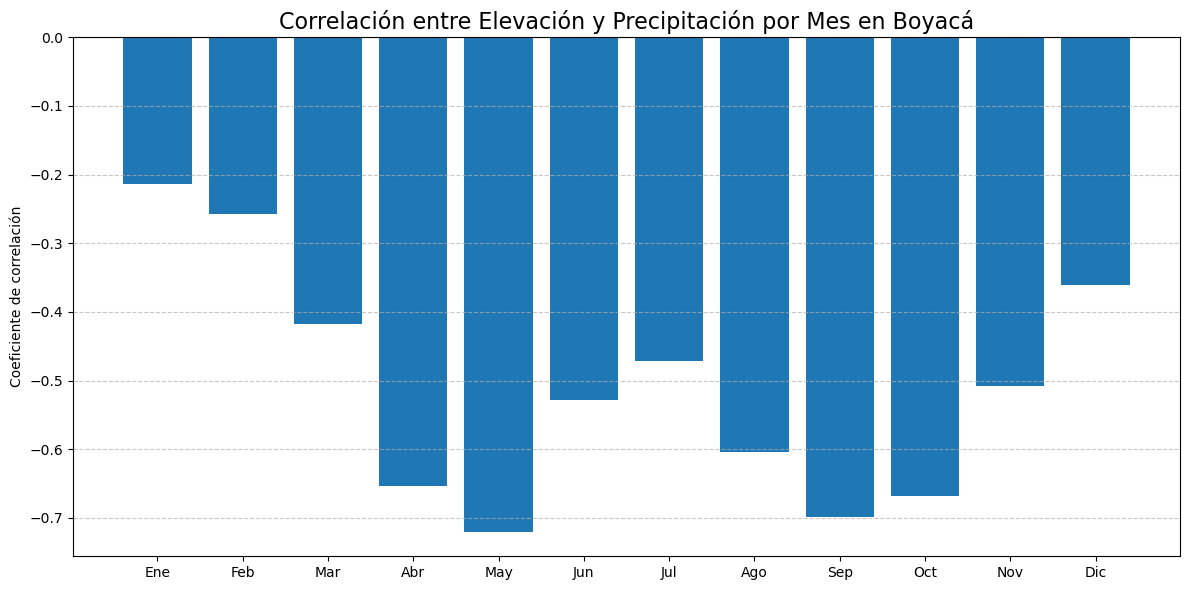


Meses con correlación positiva (a mayor elevación, mayor precipitación):

Meses con correlación negativa (a mayor elevación, menor precipitación):
- Ene: -0.213
- Feb: -0.257
- Mar: -0.418
- Abr: -0.654
- May: -0.720
- Jun: -0.529
- Jul: -0.471
- Ago: -0.604
- Sep: -0.699
- Oct: -0.668
- Nov: -0.508
- Dic: -0.361


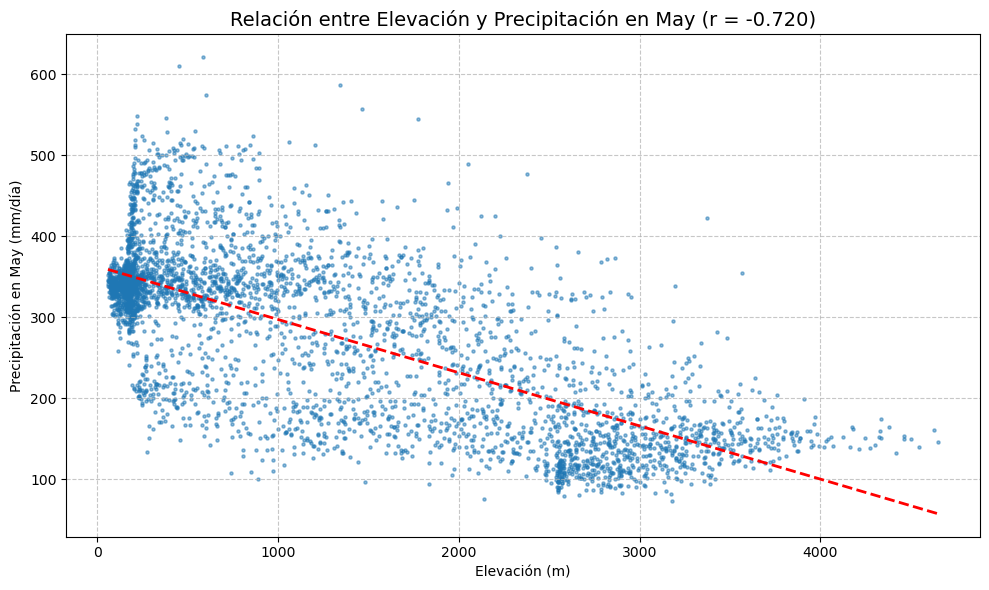

In [80]:
try:
    # Calcular correlación entre elevación y precipitación para Boyacá
    correlaciones = calcular_correlacion_elevacion_precipitacion(ds_boyaca)
    
    # Visualizar correlaciones mensuales
    plt.figure(figsize=(12, 6))
    plt.bar(correlaciones.index, correlaciones['correlacion'])
    plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
    plt.xticks(range(1, 13), nombres_meses)
    plt.ylabel('Coeficiente de correlación')
    plt.title('Correlación entre Elevación y Precipitación por Mes en Boyacá', fontsize=16)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    
    # Identificar meses con correlación positiva y negativa
    meses_corr_pos = correlaciones[correlaciones['correlacion'] > 0]
    meses_corr_neg = correlaciones[correlaciones['correlacion'] < 0]
    
    print("\nMeses con correlación positiva (a mayor elevación, mayor precipitación):")
    for mes, row in meses_corr_pos.iterrows():
        print(f"- {nombres_meses[mes-1]}: {row['correlacion']:.3f}")
        
    print("\nMeses con correlación negativa (a mayor elevación, menor precipitación):")
    for mes, row in meses_corr_neg.iterrows():
        print(f"- {nombres_meses[mes-1]}: {row['correlacion']:.3f}")
    
    # Visualizar la relación entre elevación y precipitación para un mes específico
    # Elegir el mes con la correlación más fuerte (positiva o negativa)
    mes_max_corr = correlaciones['correlacion'].abs().idxmax()
    mes_name = nombres_meses[mes_max_corr-1]
    corr_value = correlaciones.loc[mes_max_corr, 'correlacion']
    
    # Obtener datos para el mes seleccionado
    if 'mean_precipitation' in ds_boyaca:
        precip_mes = ds_boyaca['mean_precipitation'].sel(month_index=mes_max_corr).values
    else:
        precip_mes = ds_boyaca['total_precipitation'].groupby('time.month').mean().sel(month=mes_max_corr).values
    
    # Obtener datos de elevación
    if 'DEM' in ds_boyaca:
        dem = ds_boyaca['DEM'].isel(month_index=0).values
    elif 'elevation' in ds_boyaca:
        dem = ds_boyaca['elevation'].values
    
    # Crear scatter plot
    plt.figure(figsize=(10, 6))
    plt.scatter(dem.flatten(), precip_mes.flatten(), alpha=0.5, s=5)
    plt.title(f'Relación entre Elevación y Precipitación en {mes_name} (r = {corr_value:.3f})', fontsize=14)
    plt.xlabel('Elevación (m)')
    plt.ylabel(f'Precipitación en {mes_name} (mm/día)')
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Añadir línea de tendencia
    flat_dem = dem.flatten()
    flat_precip = precip_mes.flatten()
    mask = ~np.isnan(flat_dem) & ~np.isnan(flat_precip)
    valid_dem = flat_dem[mask]
    valid_precip = flat_precip[mask]
    z = np.polyfit(valid_dem, valid_precip, 1)
    p = np.poly1d(z)
    plt.plot(np.sort(valid_dem), p(np.sort(valid_dem)), 'r--', linewidth=2)
    
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"Error en el análisis de correlación: {str(e)}")

## Resumen de Hallazgos

El análisis del comportamiento bimodal de las precipitaciones en Boyacá nos permite identificar:

1. **Patrones regionales diferenciados**: Boyacá presenta un comportamiento estacional único.
   
2. **Confirmación de la bimodalidad**: Se confirma el patrón bimodal en Boyacá.
   
3. **Temporadas de lluvia**: Los picos de precipitación se concentran principalmente en dos períodos:
   - Marzo-Mayo (primer pico)
   - Septiembre-Noviembre (segundo pico)

4. **Variabilidad espacial**: Existen importantes diferencias en la distribución espacial de las precipitaciones dentro de Boyacá.

Estos resultados son consistentes con la influencia de la Zona de Convergencia Intertropical (ZCIT) y otros factores climáticos que afectan a la región.